# Raster Data Analysis

the concept of raster is definied in the first lecture [from this slide](https://docs.google.com/presentation/d/1-GkgNdFbiOBUqR-AKEmQfkZm8xKkRz43BrYWoM_YgHw/pub?start=false&loop=false&delayms=3000#slide=id.g3d5440ab2e_1_89/)

<font size="5">
<b>Outline</b>
<ul>
    <li>Earth Observation Data</li>
    <li>Raster Data Analysis</li>
    <li><a href="https://docs.google.com/presentation/d/e/2PACX-1vR8n-MMN252_yRrM74Box41QGgiOv-i80dCG73L6DE_78sSqMnfcCJYL690sK2dItRiCdYMYv0QLVN1/pub?start=false&loop=true&delayms=3000" style="color: blue;">Features Extraction (Examples) </a></li>
    <li>AI & Remote Sensing Data</li>
    <li>Practical & Examples </li>
    <li>Q&A</li>
</ul>
</font>



#Satellite Data for Earth Analysis

<font size="10"> <!-- You can adjust the font size by changing the size attribute -->

| Satellite/Sensor | Agency | Timespan      | Spatial Resolution                            | Temporal Resolution                 |
|------------------|--------|---------------|----------------------------------------------|------------------------------------|
| [Landsat](https://landsat.gsfc.nasa.gov/)          | NASA   | 1984-present  | 30 m (multispectral), 15 m (panchromatic)    | 16 days                             |
| [MODIS](https://www.earthdata.nasa.gov/sensors/modis)            | NASA   | 2000-present  | 250-1000 m                                   | Daily                               |
| [SWOT](https://swot.jpl.nasa.gov/)             | NASA   | 2022-present  | 50 m                                         | 21 days (equator), 10-11 days (mid-latitudes) |
| [Sentinel-1 A](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2)     | ESA    | 2014-present  | 5-20 m (depending on mode)                   | 6 days                              |
| [Sentinel-2 A/B](https://www.esa.int/Applications/Observing_the_Earth/Copernicus/Sentinel-2)   | ESA    | 2015-present  | 10 m                                         | 5 days (with both satellites)       |

</font>

#Step 1: Notebook Setup
Installing Necessary Libraries

In [1]:
!pip install -r https://napo.github.io/geospatial_unitn_2024/requirements_raster.txt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 GB 511.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 83.6 MB/s eta 0:00:00


In [2]:
import rasterio
from rasterio.plot import show
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt


Access Google Drive

#Step 2: Data Acquisition

##Guide to Manually Download Sentinel-2 Data
1. Access the Hub
Visit Copernicus [Open Access Hub](https://scihub.copernicus.eu/).
Log in or register if you're a new user.
2. Search for Data
Select your area of interest on the map.
Choose your time range and set S2MSI1C for Sentinel-2 Level-1C data.
Apply a cloud cover filter (e.g., 0-10%).
3. Download
Browse the results, click on relevant datasets.
Download by clicking the cloud icon with a downward arrow.


![Area of Study](https://drive.google.com/uc?export=view&id=1WuN_8B8aEHc6KbiFHrNgP7kyRDkOIF5g)


You can download the image directly from the Github repository of the course here<br/>https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/AOI_Sentinel2_RGB.tif

## Sentinel-2 Bands Overview
Sentinel-2 satellites (Sentinel-2A and Sentinel-2B) capture images in 13 spectral bands. These bands cover various parts of the spectrum from the visible, near-infrared, to short-wave infrared:

- Visible (VIS): Bands 2 (Blue), 3 (Green), 4 (Red) – primarily used for viewing and analysis that simulates human eyesight and basic vegetation health.
- Near-Infrared (NIR): Band 8 – often used for vegetation monitoring and calculating indices like NDVI.
- Red Edge Bands: Bands 5, 6, 7 – these are particularly useful for more detailed vegetation analysis and monitoring.
- Short Wave Infrared (SWIR): Bands 11, 12 – used for moisture content analysis, vegetation stress, and other applications.
- Additional Bands: Band 1 (coastal/aerosol), Band 8a, Band 9 (water vapor), and Band 10 (cirrus) – used for atmospheric corrections and specialized applications.

#Step 3: Data Loading and Visualization
- Loading Raster Data (Sentinel-2 in this tutorial)
- Visualizing Raster Data (with different bands)

In [3]:
url_AOI_Sentinel2_RGB = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/AOI_Sentinel2_RGB.tif'
# Open the raster file
with rasterio.open(url_AOI_Sentinel2_RGB) as src:
    print("Number of bands:", src.count)
    for i in range(1, src.count + 1):
        print(f"Band {i} type:", src.dtypes[i - 1])


Number of bands: 3
Band 1 type: float64
Band 2 type: float64
Band 3 type: float64


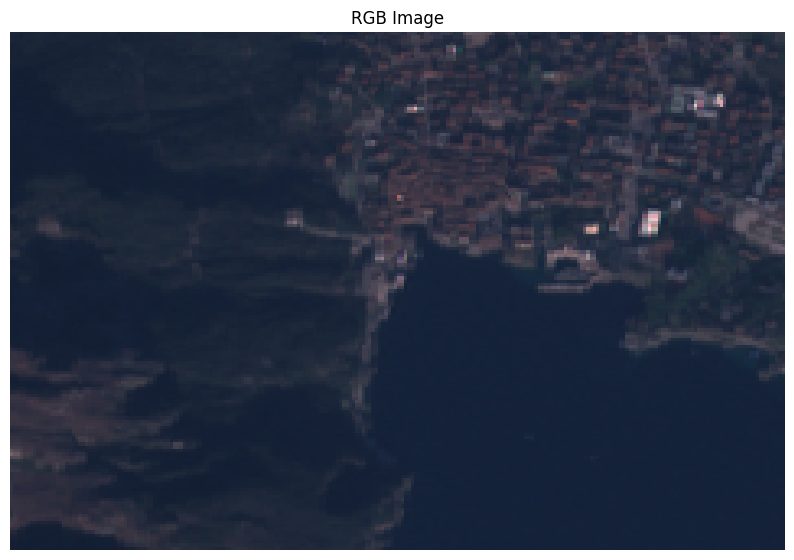

In [4]:
def display_rgb_image(file_path):
    """ Display an RGB TIFF image directly """
    with rasterio.open(file_path) as src:
        # Read the RGB bands
        rgb = src.read([1, 2, 3])  # Assuming the first three bands are RGB
        # Transpose the array dimensions from (bands, rows, cols) to (rows, cols, bands)
        rgb = rgb.transpose((1, 2, 0))

        # Scale the values if necessary (for display purposes)
        if rgb.max() > 255:
            rgb = rgb / rgb.max() * 255

        plt.figure(figsize=(10, 10))
        plt.imshow(rgb.astype('uint8'))
        plt.title("RGB Image")
        plt.axis('off')  # Hide axes ticks
        plt.show()

# Display the image
display_rgb_image(url_AOI_Sentinel2_RGB)


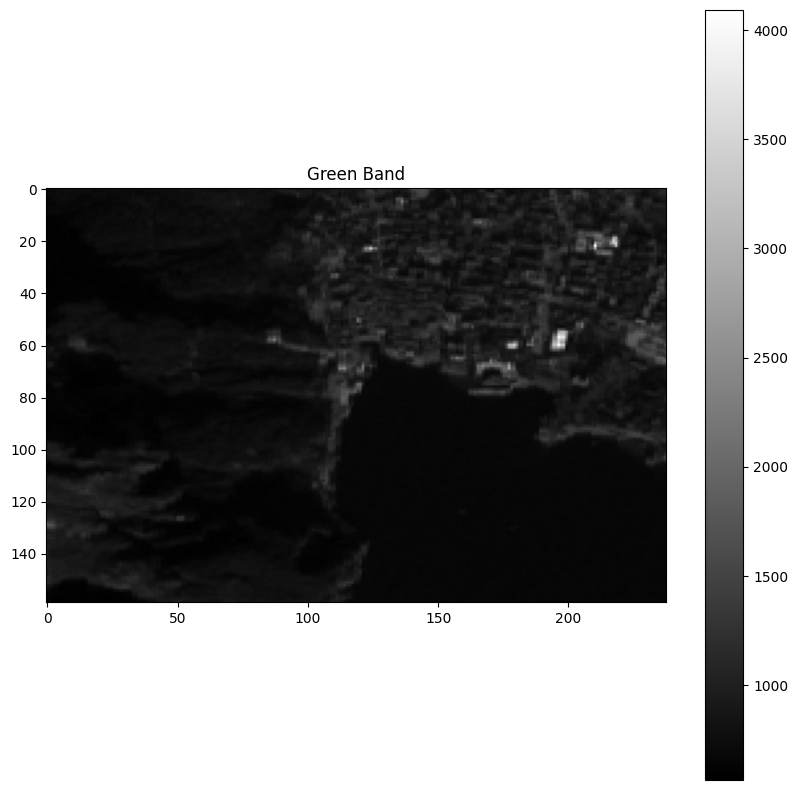

In [5]:
def load_and_plot_band(file_path, band_number, title):
    """ Load a specific band and plot it """
    with rasterio.open(file_path) as src:
        band = src.read(band_number)
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(band, cmap='gray')
    plt.colorbar()
    plt.show()
# Load and plot the Green band (Band 2)
load_and_plot_band(url_AOI_Sentinel2_RGB, 2, "Green Band")


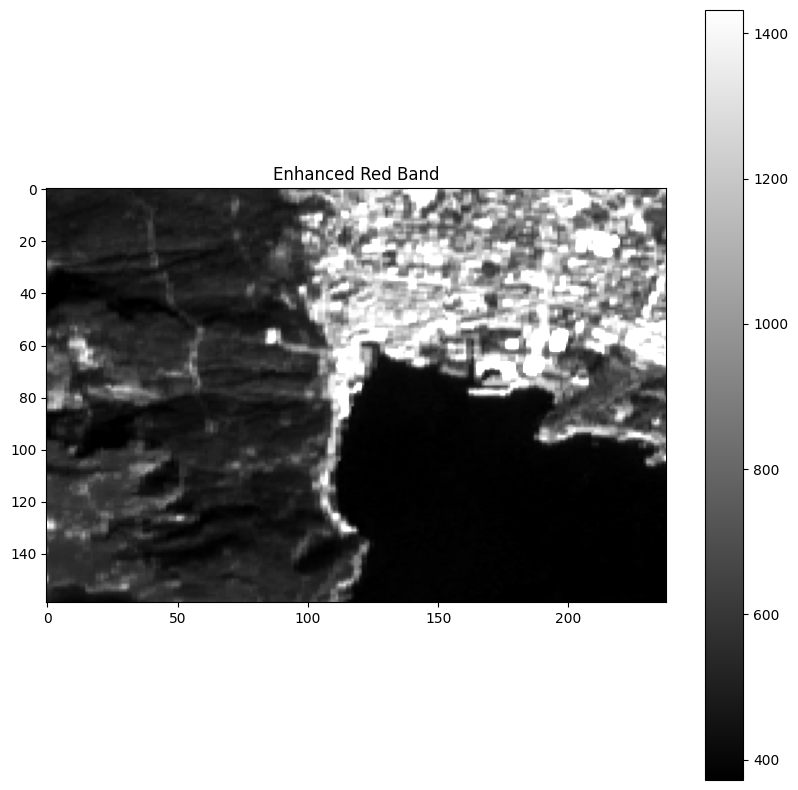

In [6]:
url_NIR_R_NDVI_Sentinel2 = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/NIR_R_NDVI_Sentinel2_Image.tif'  # Update with your actual file path
band_number = 1  # Example for single band

with rasterio.open(url_NIR_R_NDVI_Sentinel2 ) as src:
    band = src.read(band_number)

plt.figure(figsize=(10, 10))
plt.title("Enhanced Red Band")
plt.imshow(band, cmap='gray', vmin=np.percentile(band, 5), vmax=np.percentile(band, 95))  # Adjust percentiles for contrast
plt.colorbar()
plt.show()


#Step 4: Remote Sensing (Raster Data) Analysis

#4.1-Waterbodies Detection
RGB can be used to detect water bodies through their distinct color and textural differences from surrounding land.

- Normalize the Image Data Correctly

In [7]:
def load_rgb_image(file_path):
    """ Load and normalize an RGB image from a multi-band raster file. """
    with rasterio.open(url_AOI_Sentinel2_RGB) as src:
        r = src.read(1).astype(float)  # Band 1 as Red
        g = src.read(2).astype(float)  # Band 2 as Green
        b = src.read(3).astype(float)  # Band 3 as Blue
    rgb = np.stack((r, g, b), axis=-1)
    rgb /= rgb.max()  # Normalize by the maximum value in the entire image
    return rgb


- Adjust Water Detection Logic



In [8]:
def detect_water(rgb_image):
    """ Detect water bodies in an RGB image based on improved criteria. """
    # Normalize the channels individually to improve contrast
    rgb_norm = np.zeros_like(rgb_image)
    for i in range(3):
        rgb_norm[:, :, i] = rgb_image[:, :, i] / np.percentile(rgb_image[:, :, i], 99)  # Normalize each channel by its 99th percentile

    # Water detection based on low intensity and high blue component
    blue_dominance = rgb_norm[:, :, 2] > np.maximum(rgb_norm[:, :, 0], rgb_norm[:, :, 1]) * 1.1
    low_intensity = rgb_norm.mean(axis=2) < 0.99  # Adjust this threshold to catch darker areas of water
    water_mask = blue_dominance & low_intensity
    return water_mask


- Visualize & Compare the Results

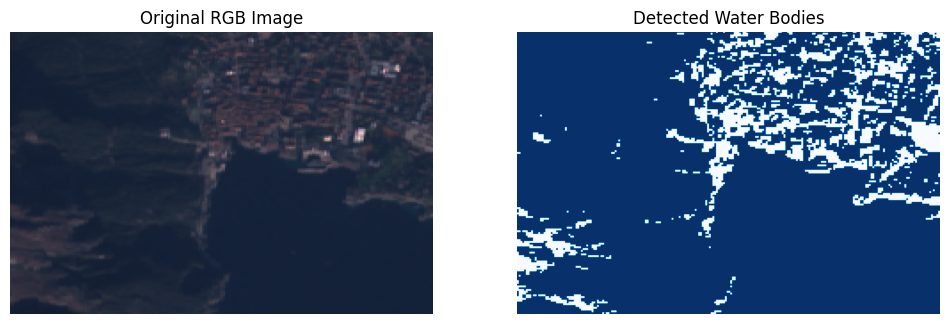

In [9]:
rgb_image = load_rgb_image(url_AOI_Sentinel2_RGB)
water_mask = detect_water(rgb_image)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title('Original RGB Image')
plt.imshow(rgb_image)
plt.axis('off')

plt.subplot(122)
plt.title('Detected Water Bodies')
plt.imshow(water_mask, cmap='Blues')
plt.axis('off')
plt.show()


#4.2 - Calculate Slope using Digital Surface Model (DSM)
DSM data is a form of raster data where each pixel in the image represents the elevation at that specific location. It can be downloaded from various sources like [USGS](https://earthexplorer.usgs.gov/) and [NASA](https://search.earthdata.nasa.gov/search#). These platforms provide comprehensive access to global DSM datasets suitable for a wide range of applications.

The following analysis can be done using DSM:
- Slope Calculation
- 3D Modeling
- Shadow Analysis
- Line of Sight Analysis

the DSM is available here<br/>
https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/DSM_AOI.tif


note: the difference between DSM and DTM is explained [here](https://docs.google.com/presentation/d/1-GkgNdFbiOBUqR-AKEmQfkZm8xKkRz43BrYWoM_YgHw/pub?start=false&loop=false&delayms=3000#slide=id.g3d65ec2902_0_0)


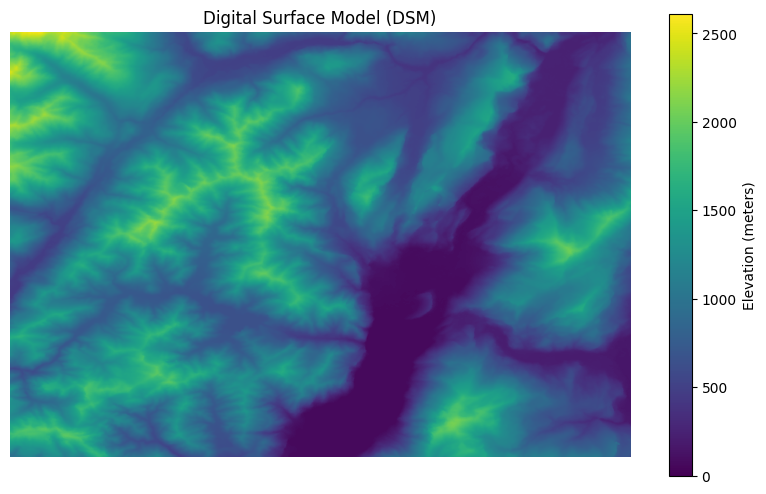

In [10]:

url_DSM_AOI = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/DSM_AOI.tif'
def display_dsm(file_path):
    """ Load and display a DSM file. """
    with rasterio.open(file_path) as src:
        # Read the DSM data
        dsm = src.read(1)  # Read the first band

        # Plot the DSM
        plt.figure(figsize=(10, 6))
        plt.title('Digital Surface Model (DSM)')
        plt.imshow(dsm, cmap='viridis')
        plt.colorbar(label='Elevation (meters)')
        plt.axis('off')  # Hide axes ticks
        plt.show()

display_dsm(url_DSM_AOI)


## 4.2.1 Slope Calculation & Shadow Analysis

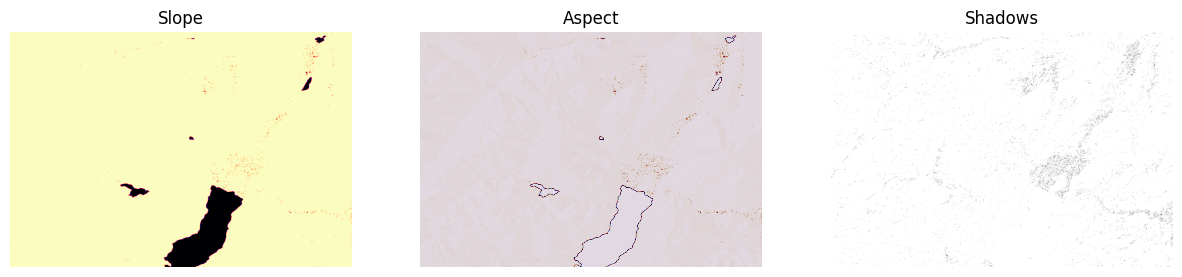

In [11]:
def calculate_slope_aspect(dsm_path):
    """ Calculate slope and aspect from a DSM path using GDAL. """
    # Load the dataset
    ds = gdal.Open(dsm_path)

    # Compute slope and aspect
    slope_ds = gdal.DEMProcessing('', ds, 'slope', format='MEM', computeEdges=True)
    aspect_ds = gdal.DEMProcessing('', ds, 'aspect', format='MEM', computeEdges=True)

    # Read slope and aspect into arrays
    slope = slope_ds.GetRasterBand(1).ReadAsArray()
    aspect = aspect_ds.GetRasterBand(1).ReadAsArray()

    return slope, aspect

def detect_shadows(slope, aspect, sun_azimuth=315, sun_elevation=35):
    """ Detect shadows based on slope, aspect, and sun position. """
    azimuth_rad = np.deg2rad(sun_azimuth)
    aspect_rad = np.deg2rad(aspect)
    slope_rad = np.deg2rad(slope)

    # Calculate shadows: shadow occurs where the terrain is oriented away from the sun more than the sun's elevation angle
    shadows = slope_rad > np.arctan(np.tan(np.deg2rad(sun_elevation)) / np.cos(azimuth_rad - aspect_rad))
    return shadows.astype(int)

# Path to your DSM data in GeoTIFF format
url_DSM_AOI = 'https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/DSM_AOI.tif'

# Calculate slope and aspect
slope, aspect = calculate_slope_aspect(url_DSM_AOI)

# Detect shadows
shadows = detect_shadows(slope, aspect)

# Plot results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(slope, cmap='magma')
ax[0].set_title('Slope')
ax[0].axis('off')

ax[1].imshow(aspect, cmap='twilight')
ax[1].set_title('Aspect')
ax[1].axis('off')

ax[2].imshow(shadows, cmap='gray')
ax[2].set_title('Shadows')
ax[2].axis('off')

plt.show()




#4.3- Calculating Normalized Difference Vegetation Index (NDVI)
The Normalized Difference Vegetation Index (NDVI) is calculated using the formula:

$$
\text{NDVI} = \frac{(NIR - Red)}{(NIR + Red)}
$$

Where:
- *NIR* represents the reflectance in the Near-Infrared band.
- *Red* represents the reflectance in the Red band.

This index is a key indicator of vegetation health, as it quantifies vegetation greenness and biomass.


In [12]:
# Open the raster file
url_NIR_R_NDVI_Sentinel2
with rasterio.open(url_NIR_R_NDVI_Sentinel2) as src:
    print("Number of bands:", src.count)
    for i in range(1, src.count + 1):
        print(f"Band {i} type:", src.dtypes[i - 1])

Number of bands: 2
Band 1 type: float64
Band 2 type: float64


- B4 (Red) (Band 1) and B8 (Near-Infrared or NIR) (Band 2), which are exactly what we need for NDVI calculations.

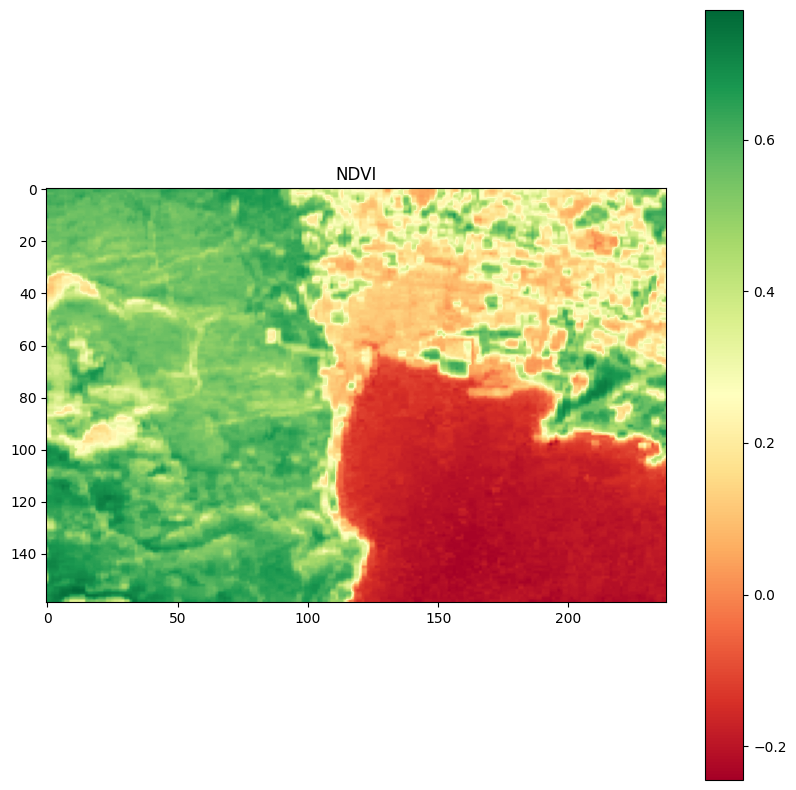

In [13]:
# Function to load a specific band from the raster file
def load_raster_data(file_path, band_number):
    """ Load a specific band from a multi-band raster file """
    with rasterio.open(file_path) as src:
        band = src.read(band_number)
    return band

# Update the path to your multi-band raster file
# Load NIR band (now as the second band, i.e., Band 8)
nir_band = load_raster_data(url_NIR_R_NDVI_Sentinel2
, band_number=2)

# Load Red band (now as the first band, i.e., Band 4)
red_band = load_raster_data(url_NIR_R_NDVI_Sentinel2
, band_number=1)

# Function to calculate NDVI
def calculate_ndvi(nir_band, red_band):
    """Calculate NDVI from NIR and Red bands"""
    nir = nir_band.astype(float)
    red = red_band.astype(float)
    ndvi = (nir - red) / (nir + red)
    ndvi[np.isnan(ndvi)] = 0  # Handle division by zero
    return ndvi

# Calculate NDVI
ndvi = calculate_ndvi(nir_band, red_band)

# Function to plot NDVI
def plot_ndvi(ndvi):
    """ Plot NDVI """
    plt.figure(figsize=(10, 10))
    plt.title("NDVI")
    plt.imshow(ndvi, cmap='RdYlGn')
    plt.colorbar()
    plt.show()
# Plotting the NDVI
plot_ndvi(ndvi)


#Key Points
<div style="font-size: 16px;">
    <strong>NDVI values range from -1 to +1.</strong><br>
    <strong> - High NDVI Values (<span style="color: green;">Green</span>)</strong>: signify healthy, dense, and vigorous vegetation with high photosynthetic activity.
     <br>
<strong> - Low NDVI Values (<span style="color: red;">Red</span> and <span style="color: yellow;">Yellow</span>)</strong>: indicate little to no vegetation presence, typically seen in urban or barren areas, or possibly water bodies where NDVI can approach negative values.<br>
<strong> - Moderate NDVI Values (<span style="color: orange;">Orange</span> to <span style="color: lightgreen;">Light Green</span>)</strong>: are indicative of grasslands, crop fields in early stages, or forests that aren't very dense.
</div>

#4.4 - Histogram equalization to each channel of an RGB
The function enhances the contrast of each channel (Red, Green, Blue) of the RGB image using histogram equalization.

- Histogram equalization is a technique in image processing used to improve the contrast of an image. It achieves this by effectively spreading out the most frequent intensity values across the entire available range. When applied to each channel of an RGB image independently, histogram equalization adjusts the contrast of each color channel (Red, Green, and Blue), enhancing the overall visual quality of the image by making colors appear more vivid and details more distinct. This method is particularly useful in enhancing the contrast of images in areas that are darker or washed out.

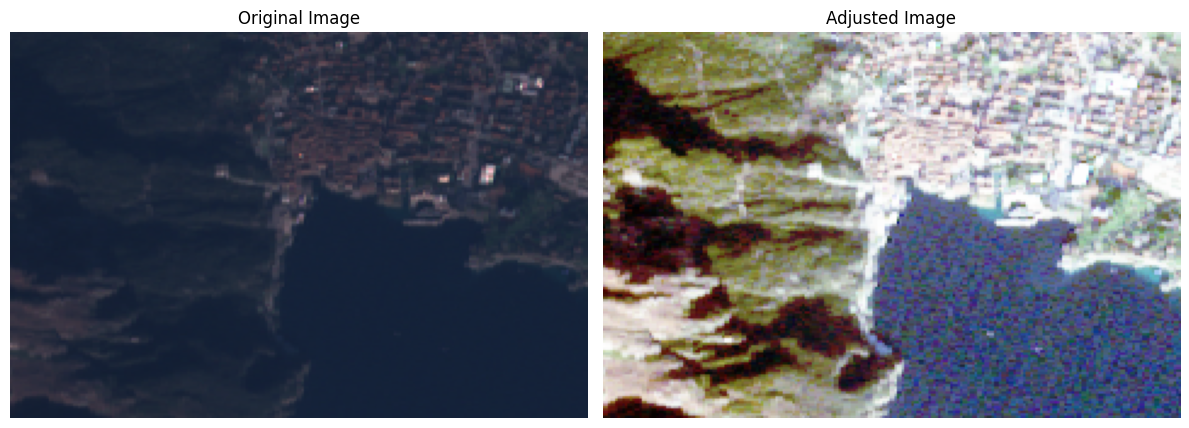

In [14]:
from skimage import exposure
# Assuming 'rgb_image' is your loaded and normalized image
def equalize_rgb_histogram(rgb_image):
    """ Apply histogram equalization to each channel of the RGB image """
    img_eq = np.zeros_like(rgb_image)
    for i in range(3):  # Apply equalization to each channel
        img_eq[..., i] = exposure.equalize_hist(rgb_image[..., i])
    return img_eq

# Equalize the histogram of the RGB image
rgb_eq = equalize_rgb_histogram(rgb_image)

def plot_comparison(original, adjusted, title_original="Original Image", title_adjusted="Adjusted Image"):
    """ Plot the original and adjusted images side by side for comparison """
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), sharex=True, sharey=True)
    ax1.imshow(original)
    ax1.set_title(title_original)
    ax1.axis('off')
    ax2.imshow(adjusted)
    ax2.set_title(title_adjusted)
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

# Display the original and equalized images
plot_comparison(rgb_image, rgb_eq)


<font size="5">
<b>Outline</b>
<ul>
    <li>Earth Observation Data</li>
    <li>Raster Data Analysis</li>
    <li>Features Extraction</a></li>
    <li> <a href="https://docs.google.com/presentation/d/e/2PACX-1vR8n-MMN252_yRrM74Box41QGgiOv-i80dCG73L6DE_78sSqMnfcCJYL690sK2dItRiCdYMYv0QLVN1/pub?start=false&loop=true&delayms=3000" style="color: blue;">AI & Remote Sensing Data </a> </li>
    <li>Practical & Examples </li>
    <li>Q&A</li>
</ul>
</font>

 # Introduction to AI in Remote Sensing
- Common deep learning models used in remote sensing for features extraction (un-supervised or supervised classification).


In [15]:
# this command is used the check if the machine has the GPU support
!nvidia-smi

Thu Oct 17 18:41:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##Installing Necessary Computer Vision Libraries
- Open Source Computer Vision (OpenCV)
- Python Imaging Library (PIL)
- Scikit-image
- TensorFlow and Keras
- Rasterio


# Clustering K-Means Technique on Sentinel-2 (Unspervised Classification)
Clustering techniques in unsupervised classification involve grouping a set of objects in such a way that objects in the same group (or cluster) are more similar to each other than to those in other groups.

- Let's start with a single band image

In [16]:
from sklearn import cluster
from osgeo import gdal, gdal_array

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

# Read in raster image
# img_ds = gdal.Open('/content/drive/MyDrive/Geospatial_Lecture_18thNov2024/AOI_Sentinel2_RGB.tif', gdal.GA_ReadOnly)
img_ds = gdal.Open(url_AOI_Sentinel2_RGB, gdal.GA_ReadOnly)

band = img_ds.GetRasterBand(2)

img = band.ReadAsArray()
print (img.shape)

X = img.reshape((-1,1))
print (X.shape)


k_means = cluster.KMeans(n_clusters=8) #adjust number of clusters to see more varoations in classes
k_means.fit(X)

X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img.shape)

print (len(X_cluster))

(159, 238)
(37842, 1)
159


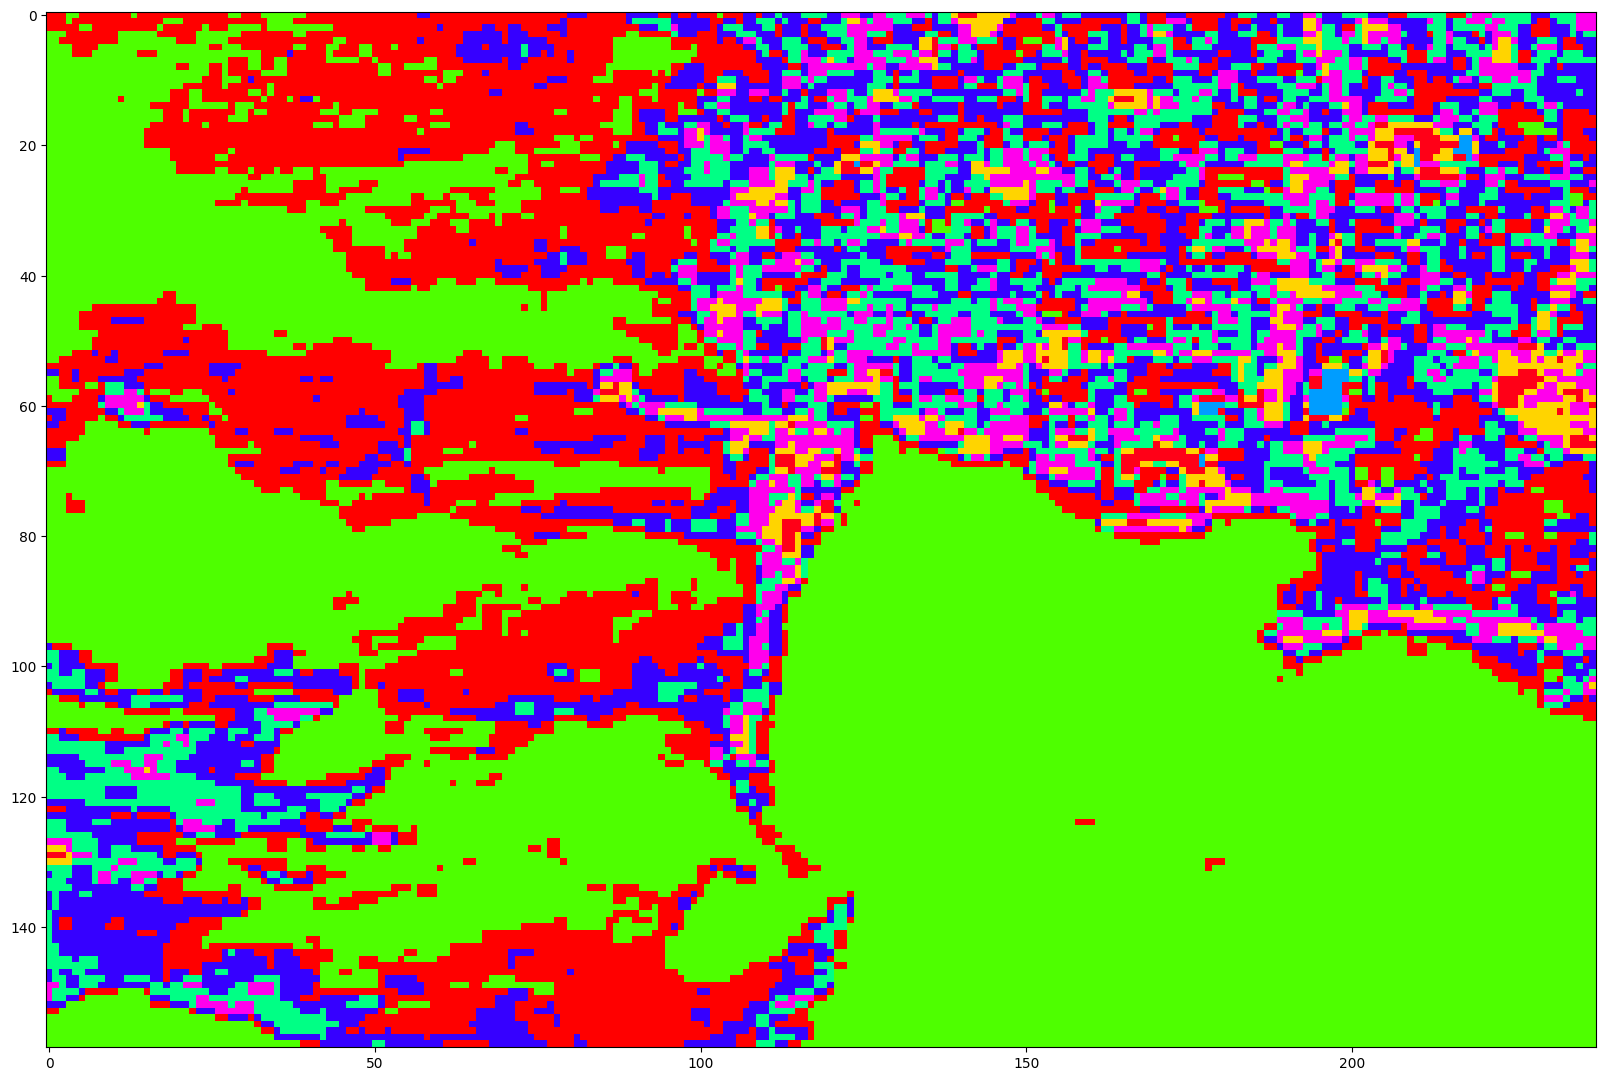

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

- What about using all 13 bands of Sentinel-2?
- Remember you need to download the Sentinel-2 data with all bands (13) information not only RGB.

In [18]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()
url_South_coast = "https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/South_coast.tif"
# Read in raster image
img_ds = gdal.Open(url_South_coast, gdal.GA_ReadOnly)


img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

new_shape = (img.shape[0] * img.shape[1], img.shape[2])
print (img.shape)

print (new_shape)


X = img[:, :, :13].reshape(new_shape)

print (X.shape)

(519, 751, 3)
(389769, 3)
(389769, 3)


In [19]:
k_means = cluster.KMeans(n_clusters=8)
k_means.fit(X)
X_cluster = k_means.labels_
X_cluster = X_cluster.reshape(img[:, :, 0].shape)

In [20]:
print (X_cluster.shape)
plt.figure(figsize=(20,20))
plt.imshow(X_cluster, cmap="hsv")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Supervised Classification deep learning models:

In supervised classification in deep learning, models are trained using a large amount of annotated/labeled data to learn to predict the class or category of new, unseen data, effectively making them powerful tools in computer vision.
- U-Net for semantic segmentation.

- YOLO (You Only Look Once) for object detection.

#Unet Training & Prediciting
Importing Libraries

In [21]:
import cv2
import os
from tqdm.notebook import tqdm
from random import shuffle
import torch
from torch import nn
import math
from glob import glob
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Loading and Preprocessing Data

In [22]:
import urllib
import os
import zipfile, io

In [23]:
 # download the data
url_segmentation_of_aerial_imagery = "https://github.com/napo/geospatial_unitn_2024/raw/refs/heads/main/data/raster/Semantic%20segmentation%20of%20aerial%20imagery.zip"
segmentation_of_aerial_imagery_file = "Semantic segmentation of aerial imagery.zip"
urllib.request.urlretrieve(url_segmentation_of_aerial_imagery ,segmentation_of_aerial_imagery_file)
z = zipfile.ZipFile(segmentation_of_aerial_imagery_file)
# unzip the file
z.extractall()

In [24]:
import torch.utils.data
import torchvision.transforms as transforms
import PIL
import random
from scipy import ndimage


class segDataset(torch.utils.data.Dataset):
    def __init__(self, root, training, transform=None):
        super(segDataset, self).__init__()
        self.root = root
        self.training = training
        self.transform = transform
        self.IMG_NAMES = sorted(glob(self.root + '/*/images/*.jpg'))
        self.BGR_classes = {'Water' : [ 41, 169, 226],
                            'Land' : [246,  41, 132],
                            'Road' : [228, 193, 110],
                            'Building' : [152,  16,  60],
                            'Vegetation' : [ 58, 221, 254],
                            'Unlabeled' : [155, 155, 155]} # in BGR

        self.bin_classes = ['Water', 'Land', 'Road', 'Building', 'Vegetation', 'Unlabeled']


    def __getitem__(self, idx):
        img_path = self.IMG_NAMES[idx]
        mask_path = img_path.replace('images', 'masks').replace('.jpg', '.png')

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path)
        cls_mask = np.zeros(mask.shape)
        cls_mask[mask == self.BGR_classes['Water']] = self.bin_classes.index('Water')
        cls_mask[mask == self.BGR_classes['Land']] = self.bin_classes.index('Land')
        cls_mask[mask == self.BGR_classes['Road']] = self.bin_classes.index('Road')
        cls_mask[mask == self.BGR_classes['Building']] = self.bin_classes.index('Building')
        cls_mask[mask == self.BGR_classes['Vegetation']] = self.bin_classes.index('Vegetation')
        cls_mask[mask == self.BGR_classes['Unlabeled']] = self.bin_classes.index('Unlabeled')
        cls_mask = cls_mask[:,:,0]

        if self.training==True:
            if self.transform:
              image = transforms.functional.to_pil_image(image)
              image = self.transform(image)
              image = np.array(image)

            # 90 degree rotation
            if np.random.rand()<0.5:
              angle = np.random.randint(4) * 90
              image = ndimage.rotate(image,angle,reshape=True)
              cls_mask = ndimage.rotate(cls_mask,angle,reshape=True)

            # vertical flip
            if np.random.rand()<0.5:
              image = np.flip(image, 0)
              cls_mask = np.flip(cls_mask, 0)

            # horizonal flip
            if np.random.rand()<0.5:
              image = np.flip(image, 1)
              cls_mask = np.flip(cls_mask, 1)

        image = cv2.resize(image, (512,512))/255.0
        cls_mask = cv2.resize(cls_mask, (512,512))
        image = np.moveaxis(image, -1, 0)

        return torch.tensor(image).float(), torch.tensor(cls_mask, dtype=torch.int64)


    def __len__(self):
        return len(self.IMG_NAMES)

In [25]:
color_shift = transforms.ColorJitter(.1,.1,.1,.1)
blurriness = transforms.GaussianBlur(3, sigma=(0.1, 2.0))

t = transforms.Compose([color_shift, blurriness])
dataset = segDataset('./Semantic segmentation dataset', training = True, transform= t)

len(dataset)

72

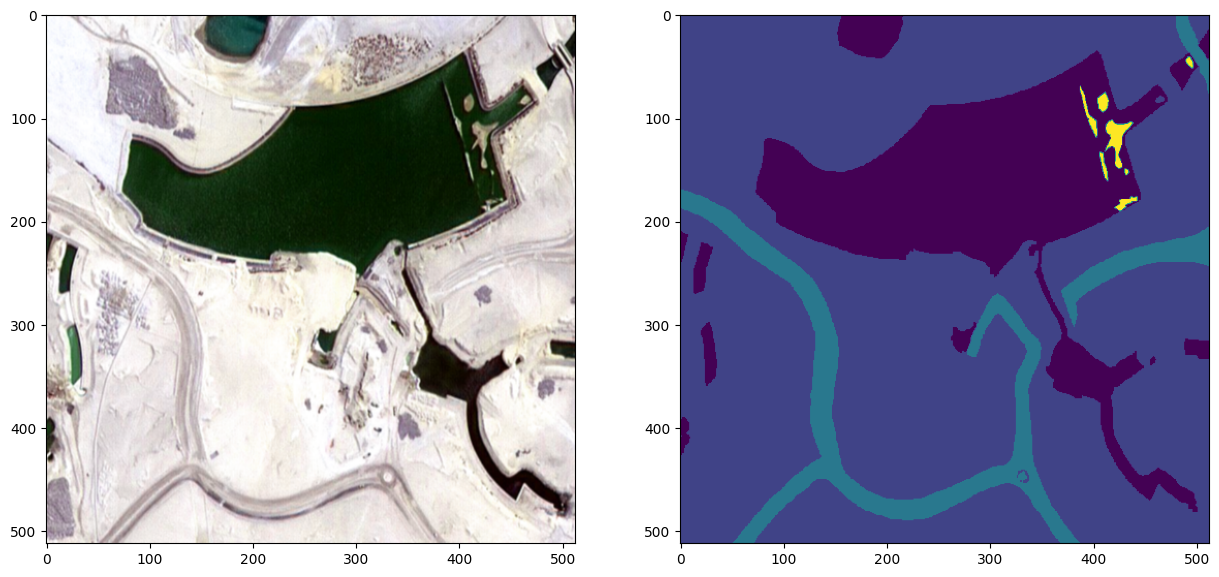

In [26]:
d = dataset[1]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(np.moveaxis(d[0].numpy(),0,-1))
plt.subplot(1,2,2)
plt.imshow(d[1].numpy())

In [27]:
test_num = int(0.1 * len(dataset))
print(f'test data : {test_num}')
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset)-test_num, test_num], generator=torch.Generator().manual_seed(101))

test data : 7


In [28]:
BACH_SIZE = 4
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BACH_SIZE, shuffle=True, num_workers=4)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=BACH_SIZE, shuffle=False, num_workers=1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Unet - Model

In [29]:
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [30]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

## LOSS

In [31]:
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim=-1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [32]:
criterion = FocalLoss(gamma=3/4).to(device)

##Jaccard Loss

In [33]:
class mIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True, n_classes=2):
        super(mIoULoss, self).__init__()
        self.classes = n_classes

    def to_one_hot(self, tensor):
        n,h,w = tensor.size()
        one_hot = torch.zeros(n,self.classes,h,w).to(tensor.device).scatter_(1,tensor.view(n,1,h,w),1)
        return one_hot

    def forward(self, inputs, target):
        # inputs => N x Classes x H x W
        # target_oneHot => N x Classes x H x W

        N = inputs.size()[0]

        # predicted probabilities for each pixel along channel
        inputs = F.softmax(inputs,dim=1)

        # Numerator Product
        target_oneHot = self.to_one_hot(target)
        inter = inputs * target_oneHot
        ## Sum over all pixels N x C x H x W => N x C
        inter = inter.view(N,self.classes,-1).sum(2)

        #Denominator
        union= inputs + target_oneHot - (inputs*target_oneHot)
        ## Sum over all pixels N x C x H x W => N x C
        union = union.view(N,self.classes,-1).sum(2)

        loss = inter/union

        ## Return average loss over classes and batch
        return 1-loss.mean()

In [34]:
criterion = mIoULoss(n_classes=6).to(device)

##Training

In [35]:
def acc(label, predicted):
  seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
  return seg_acc

In [36]:
min_loss = torch.tensor(float('inf'))
model = UNet(n_channels=3, n_classes=6, bilinear=True).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [37]:
os.makedirs('./saved_models', exist_ok=True)

N_EPOCHS = 100
N_DATA = len(train_dataset)
N_TEST = len(test_dataset)

plot_losses = []
scheduler_counter = 0

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(train_dataloader):

      pred_mask = model(x.to(device))
      loss = criterion(pred_mask, y.to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      sys.stdout.write(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(train_dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(test_dataloader):
      with torch.no_grad():
          pred_mask = model(x.to(device))
      val_loss = criterion(pred_mask, y.to(device))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                 np.mean(loss_list),
                                                                                                 np.mean(acc_list),
                                                                                                 np.mean(val_loss_list),
                                                                                                 np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))

  if scheduler_counter > 5:
    lr_scheduler.step()
    print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
    scheduler_counter = 0


[Epoch 0/100] [Batch 16/17] [Loss: 0.810268 (0.839918)] epoch 0 - loss : 0.83992 - acc : 0.58 - val loss : 0.88315 - val acc : 0.60
[Epoch 1/100] [Batch 16/17] [Loss: 0.813715 (0.790253)] epoch 1 - loss : 0.79025 - acc : 0.67 - val loss : 0.84522 - val acc : 0.63
[Epoch 2/100] [Batch 16/17] [Loss: 0.834410 (0.769756)] epoch 2 - loss : 0.76976 - acc : 0.67 - val loss : 0.77945 - val acc : 0.67
[Epoch 3/100] [Batch 16/17] [Loss: 0.809911 (0.752410)] epoch 3 - loss : 0.75241 - acc : 0.68 - val loss : 0.75859 - val acc : 0.67
[Epoch 4/100] [Batch 16/17] [Loss: 0.833101 (0.745254)] epoch 4 - loss : 0.74525 - acc : 0.68 - val loss : 0.74072 - val acc : 0.68
[Epoch 5/100] [Batch 16/17] [Loss: 0.936845 (0.730505)] epoch 5 - loss : 0.73051 - acc : 0.67 - val loss : 0.71350 - val acc : 0.73
[Epoch 6/100] [Batch 16/17] [Loss: 0.637075 (0.730603)] epoch 6 - loss : 0.73060 - acc : 0.67 - val loss : 0.76670 - val acc : 0.67
[Epoch 7/100] [Batch 16/17] [Loss: 0.761635 (0.723568)] epoch 7 - loss : 0.7

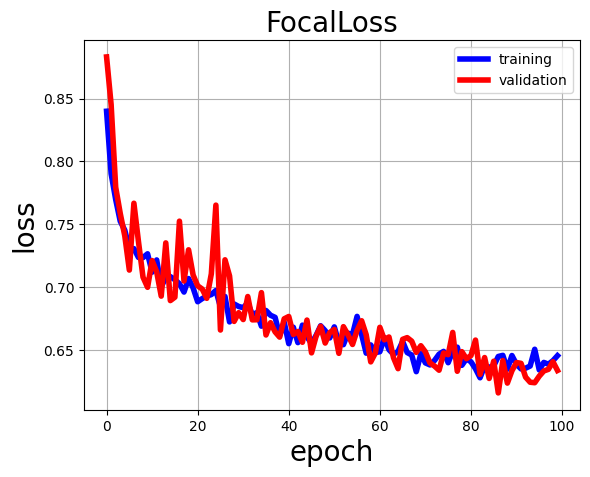

In [38]:
# plot loss
plot_losses = np.array(plot_losses)
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title('FocalLoss', fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.show()

## Testing

In [40]:
model.load_state_dict(torch.load('/content/saved_models/unet_epoch_82_0.63053.pt')) #update the path of saved model

<ipython-input-40-b595782dc373>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/saved_models/unet_epoch_82_0.63053.pt')) #update 

<All keys matched successfully>

In [44]:
model.eval()

for batch_i, (x, y) in enumerate(test_dataloader):
    for j in range(len(x)):
        result = model(x.to(device)[j:j+1])
        mask = torch.argmax(result, axis=1).cpu().detach().numpy()[0]
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        gt_mask = y[j]

        plt.figure(figsize=(12,12))

        plt.subplot(1,3,1)
        im = np.moveaxis(x.to(device)[j].cpu().detach().numpy(), 0, -1).copy()*255
        im = im.astype(int)
        plt.imshow(im)

        plt.subplot(1,3,2)
        plt.imshow(gt_mask)

        plt.subplot(1,3,3)
        plt.imshow(mask)
        plt.show()

Output hidden; open in https://colab.research.google.com to view.